# Monkey Classification: End-to-end Pipeline
In this notebook we're going to show how you can apply distributed training using Kubeflow pipelines!<br>

The dataset we're using consists of two folders; training and validation. Each folder contains 10 subforders labeled as n0~n9, each corresponding a species from Wikipedia's monkey cladogram. Images are 400x300 px or larger and JPEG format.

You'll need:
- Just this notebook
- Kubeflow deployed on either OpenShift or Kubernetes (make sure it is on IBM Power, we don't support x86!)
- Internet connection to download the sample images (you can also manually upload them to your preferred S3 bucket - e.g. minio)

Datasource: https://www.kaggle.com/slothkong/10-monkey-species

## Original Authors
- Marvin Giessing <MARVING@de.ibm.com>
- Sebastian Lehrig <sebastian.lehrig1@ibm.com>

## Edited by
- Nick Lawrence ntl@us.ibm.com

## References
- https://www.philschmid.de/image-classification-huggingface-transformers-keras
- https://discuss.huggingface.co/t/solved-image-dataset-seems-slow-for-larger-image-size/10960/6

## License
Apache-2.0 License

## 0.) Imports & Constants

In [42]:
import cv2
import json
import kfp
from kfp.components import InputPath, OutputPath
import kfp.dsl as dsl
from kfp.dsl import PipelineConf, data_passing_methods
from kubernetes.client.models import V1Volume, V1PersistentVolumeClaimVolumeSource
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
from typing import List, NamedTuple

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [43]:
COMPONENT_CATALOG_FOLDER = f"{os.getenv('HOME')}/components"

LOAD_DATASET_COMPONENT = (
    f"{COMPONENT_CATALOG_FOLDER}/data-collection/load-dataset/component.yaml"
)
TRAIN_MODEL_COMPONENT = (
    f"{COMPONENT_CATALOG_FOLDER}/model-building/train-model-job/component.yaml"
)
PLOT_CONFUSION_MATRIX_COMPONENT = (
    f"{COMPONENT_CATALOG_FOLDER}/model-building/plot-confusion-matrix/component.yaml"
)
CONVERT_MODEL_TO_ONNX_COMPONENT = (
    f"{COMPONENT_CATALOG_FOLDER}/model-building/convert-to-onnx/component.yaml"
)
UPLOAD_MODEL_COMPONENT = (
    f"{COMPONENT_CATALOG_FOLDER}/model-building/upload-model/component.yaml"
)

DEPLOY_MODEL_COMPONENT = f"{os.getenv('HOME')}/kubeflow-ppc64le-examples/deploy_triton_inference_service_component/deploy_triton_inference_service_component.yaml"


BASE_IMAGE = (
    "quay.io/ibm/kubeflow-notebook-image-ppc64le:elyra3.14.1-py3.9-tf2.10.1-pt1.10.2-v0"
)

with open("/var/run/secrets/kubernetes.io/serviceaccount/namespace") as f:
    NAMESPACE = f.read()

## 1.) Let's start with creating a client object for interaction

In [44]:
client = kfp.Client()

## 2.) The main part consists of defining the end-to-end workflow functions and create components from them

### 2.1) Load dataset (by reusing a Kubeflow component)

In [45]:
load_dataset_comp = kfp.components.load_component_from_file(LOAD_DATASET_COMPONENT)

### 2.2) Preprocess data (normalizing, one hot encoding, etc.)

In [46]:
def preprocess_dataset(
    dataset_dir: InputPath(str),
    train_dataset_dir: OutputPath(str),
    validation_dataset_dir: OutputPath(str),
    test_dataset_dir: OutputPath(str),
    test_size: float = 0.2,
    seed: int = 42,
    size: int = 224,
    batch_size: int = 16,
):
    """Split data into train/dev/test data. Saves result into `prep_dataset_dir`."""

    from datasets import Array3D, DatasetDict, Features, load_from_disk, Sequence, Value
    import numpy as np
    import os
    from transformers import DefaultDataCollator, ImageFeatureExtractionMixin

    print(f"Loading input dataset from {dataset_dir}...")
    dataset = load_from_disk(dataset_dir)
    print("Dataset loaded.")

    # Preprocess
    num_classes = dataset["train"].features["label"].num_classes
    one_hot_matrix = np.eye(num_classes)
    feature_extractor = ImageFeatureExtractionMixin()

    def to_pixels(image):
        image = feature_extractor.resize(image, size=size)
        image = feature_extractor.to_numpy_array(image, channel_first=False)
        image = image / 255.0
        return image

    def process(examples):
        examples["pixel_values"] = [to_pixels(image) for image in examples["image"]]
        examples["label"] = [one_hot_matrix[label] for label in examples["label"]]
        return examples

    features = Features(
        {
            "pixel_values": Array3D(dtype="float32", shape=(size, size, 3)),
            "label": Sequence(feature=Value(dtype="int32"), length=num_classes),
        }
    )

    print("Preprocessing dataset...")
    prep_dataset = dataset.map(
        process,
        remove_columns=["image"],
        batched=True,
        batch_size=batch_size,
        num_proc=2,
        features=features,
        keep_in_memory=True,
    )

    # prep_dataset = prep_dataset.with_format("numpy")

    # Split
    print("Splitting dataset...")
    dev_test_dataset = prep_dataset["test"].train_test_split(
        test_size=test_size, shuffle=True, seed=seed
    )

    train_dev_test_dataset = DatasetDict(
        {
            "train": prep_dataset["train"],
            "validation": dev_test_dataset["train"],
            "test": dev_test_dataset["test"],
        }
    )

    def save_as_tfdataset(
        dataset, columns, label_columns, data_collator, directory, shuffle
    ):
        import tensorflow as tf

        tf_dataset = dataset.to_tf_dataset(
            columns=columns,
            label_cols=label_columns,
            shuffle=shuffle,
            batch_size=batch_size,
            collate_fn=data_collator,
        )

        print(f"Saving pre-processed dataset to '{directory}'...")
        if not os.path.exists(directory):
            os.makedirs(directory)
        tf.data.experimental.save(tf_dataset, directory)

        print(f"Pre-processed dataset saved. Contents of '{directory}':")
        print(os.listdir(directory))

    data_collator = DefaultDataCollator(return_tensors="tf")
    columns = ["pixel_values"]
    label_columns = ["labels"]
    save_as_tfdataset(
        train_dev_test_dataset["train"],
        columns,
        label_columns,
        data_collator,
        train_dataset_dir,
        True,
    )
    save_as_tfdataset(
        train_dev_test_dataset["validation"],
        columns,
        label_columns,
        data_collator,
        validation_dataset_dir,
        False,
    )
    save_as_tfdataset(
        train_dev_test_dataset["test"],
        columns,
        label_columns,
        data_collator,
        test_dataset_dir,
        False,
    )

    print("Finished.")


preprocess_dataset_comp = kfp.components.create_component_from_func(
    func=preprocess_dataset, base_image=BASE_IMAGE
)

### 2.3 Train model (Distributed with horovod):

In [47]:
def train_distributed_model(
    train_dataset_dir: InputPath(str),
    validation_dataset_dir: InputPath(str),
    model_dir: OutputPath(str),
    epochs: int = 100,
    batch_size: int = 32,
):
    """Uses transfer learning on a prepared dataset. Once trained, the model is persisted to `model_dir`."""

    import horovod.tensorflow.keras as hvd
    import os
    import tensorflow as tf
    from tensorflow.keras import Sequential
    from tensorflow.keras.applications import InceptionV3
    from tensorflow.keras.layers import (
        BatchNormalization,
        Dense,
        Dropout,
        GlobalAveragePooling2D,
    )
    from tensorflow.keras.callbacks import (
        EarlyStopping,
        ModelCheckpoint,
        ReduceLROnPlateau,
        TensorBoard,
    )
    from horovod.tensorflow.keras.callbacks import MetricAverageCallback
    import tensorflow_datasets as tfds
    import time

    def load_datasets():
        train_dataset = tf.data.experimental.load(train_dataset_dir)
        validation_dataset = tf.data.experimental.load(validation_dataset_dir)
        return (train_dataset, validation_dataset)

    def build_model(shape):
        backbone = InceptionV3(include_top=False, weights="imagenet", input_shape=shape)

        for layer in backbone.layers:
            layer.trainable = False

        model = Sequential()
        model.add(backbone)
        model.add(GlobalAveragePooling2D())
        model.add(Dense(128, activation="relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        model.add(Dense(64, activation="relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        model.add(Dense(10, activation="softmax"))

        return model

    print("Initializing Horovod/MPI for distributed training...")
    hvd.init()

    # Pin GPU to be used to process local rank (one GPU per process)
    gpus = tf.config.experimental.list_physical_devices("GPU")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    if gpus:
        tf.config.experimental.set_visible_devices(gpus[hvd.local_rank()], "GPU")

    # Prepare distributed training with GPU support
    os.environ["NCCL_DEBUG"] = "INFO"
    tfds.disable_progress_bar()

    if hvd.rank() == 0:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

    # see https://horovod.readthedocs.io/en/stable/api.html
    print("==============================================")
    print(f"hvd.rank(): {str(hvd.rank())}")
    print(f"hvd.local_rank(): {str(hvd.local_rank())}")
    print(f"hvd.size(): {str(hvd.size())}")
    print(f"hvd.local_size(): {str(hvd.local_size())}")
    print("gpus:")
    print(gpus)
    print("==============================================")

    print("Loading datasets...")
    train_dataset, validation_dataset = load_datasets()
    shape = (224, 224, 3)

    print("Making traininig dataset ready for distributed training...")
    # Best shuffling needs a buffer with size equal to the size of the
    # dataset. Approximate values should be fine here.
    dataset_elements = 1400  # hard to determine dynamically in TFDataset
    approx_shard_train_size = dataset_elements // hvd.size() + 1

    # References:
    # - shard: https://github.com/horovod/horovod/issues/2623#issuecomment-768435610
    # - cache & prefetch: https://stackoverflow.com/questions/59228816/what-do-the-tensorflow-datasets-functions-cache-and-prefetch-do
    # - shuffle: https://stackoverflow.com/questions/64372390/what-does-buffer-size-do-in-tensorflow-dataset-shuffling
    distributed_train_dataset = (
        train_dataset.unbatch()  # Batch after sharding
        .shard(num_shards=hvd.size(), index=hvd.rank())  # 1 shard per worker
        .cache()  # Reuse data on next epoch
        .shuffle(
            buffer_size=approx_shard_train_size, seed=42, reshuffle_each_iteration=False
        )  # Randomize shards
        .batch(batch_size)
        .repeat()  # Avoid last batch being of unequal size
        .prefetch(tf.data.AUTOTUNE)  # Overlap preprocessing and training
    )

    print("Building model...")
    model = build_model(shape)
    print(model.summary())

    opt = tf.keras.optimizers.Adam(learning_rate=0.001 * hvd.size())
    # Horovod: add Horovod DistributedOptimizer.
    opt = hvd.DistributedOptimizer(opt)

    print("Compiling model...")
    # Horovod: Specify `experimental_run_tf_function=False` to ensure TensorFlow
    # uses hvd.DistributedOptimizer() to compute gradients.
    model.compile(
        optimizer=opt,
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"],
        experimental_run_tf_function=False,
    )

    print("Initializing training callbacks...")
    callbacks = [
        # https://www.olcf.ornl.gov/wp-content/uploads/2019/12/ORNL-Scaling-20200210.pdf (chart 28)
        MetricAverageCallback(),
        ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=7,
            verbose=1,
            min_delta=0.0001,
            mode="min",
        ),
        EarlyStopping(monitor="val_loss", patience=20, verbose=1, mode="min"),
        TensorBoard(
            log_dir=f"s3://mlpipeline/tensorboard/{os.environ['JOB_NAME']}",
            histogram_freq=1,
        ),
        # Horovod: broadcast initial variable states from rank 0 to all other processes.
        # This is necessary to ensure consistent initialization of all workers when
        # training is started with random weights or restored from a checkpoint.
        hvd.callbacks.BroadcastGlobalVariablesCallback(0),
    ]
    # Horovod: save checkpoints only on worker 0 to prevent other workers from corrupting them.
    if hvd.rank() == 0:
        callbacks.append(
            ModelCheckpoint(
                f"{model_dir}/best_model.keras",
                monitor="val_loss",
                save_best_only=True,
                save_weights_only=True,
                mode="min",
            )
        )

    print("Starting model training...")
    start = time.time()
    hist = model.fit(
        distributed_train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        steps_per_epoch=approx_shard_train_size // batch_size
        + 1,  # Needed when using repeat()
        callbacks=callbacks,
        verbose=1 if hvd.rank() == 0 else 0,
    )

    if hvd.rank() == 0:
        print("\n\nTraining took ", time.time() - start, "seconds")

        print("Model train history:")
        print(hist.history)

        print(f"Saving model to: {model_dir}")
        model.save(model_dir)
        print(f"Model saved to: {model_dir}")

    print(f"Finished. {hvd.rank()}")

In [48]:
train_specification = kfp.components.func_to_component_text(
    func=train_distributed_model, base_image=BASE_IMAGE
)

train_model_comp = kfp.components.load_component_from_file(TRAIN_MODEL_COMPONENT)

### 2.4) Evaluate model with validation data

In [49]:
# Pipeline metrics have problems in Kubeflow 1.6.0
# so using ui metadata here to draw a table instead
# https://github.com/kubeflow/pipelines/issues/8356
def evaluate_model(
    test_dataset_dir: InputPath(str),
    mlpipeline_ui_metadata_path: OutputPath(str),
    model_dir: InputPath(str),
    batch_size: int = 20,
):
    import json
    import tensorflow as tf
    import os

    test_dataset = tf.data.experimental.load(test_dataset_dir)
    model = tf.keras.models.load_model(model_dir)
    (loss, accuracy) = model.evaluate(test_dataset)

    print((loss, accuracy))

    metadata = {
        "outputs": [
            {
                "type": "table",
                "storage": "inline",
                "format": "csv",
                "header": ["Loss", "Accuracy"],
                "source": f"{loss},{accuracy}",
            }
        ]
    }

    with open(mlpipeline_ui_metadata_path, "w") as f:
        json.dump(metadata, f)


evaluate_model_comp = kfp.components.create_component_from_func(
    func=evaluate_model, base_image=BASE_IMAGE
)

### 2.5) Create confusion matrix (by reusing a Kubeflow component)

In [50]:
plot_confusion_matrix_comp = kfp.components.load_component_from_file(
    PLOT_CONFUSION_MATRIX_COMPONENT
)

### 2.6) Convert model to ONNX (by reusing a Kubeflow component)

In [51]:
convert_model_to_onnx_comp = kfp.components.load_component_from_file(
    CONVERT_MODEL_TO_ONNX_COMPONENT
)

### 2.7) Upload model to MinIO artifact store (by reusing a Kubeflow component)

In [52]:
upload_model_comp = kfp.components.load_component_from_file(UPLOAD_MODEL_COMPONENT)

### 2.8) Deploy the model using KServe (by reusing a Kubeflow component)

In [53]:
deploy_model_comp = kfp.components.load_component_from_file(DEPLOY_MODEL_COMPONENT)

## 3.) Create the actual pipeline by combining the components

In [54]:
blackboard_pvc: str = "artefacts"


@dsl.pipeline(
    name="End-to-end monkey species classification pipeline",
    description="An example pipeline that performs an image classification and determines different monkey species",
)
def monkey_pipeline(
    dataset_url: str = "Lehrig/Monkey-Species-Collection",
    dataset_configuration: str = "downsized",
    dataset_label_columns: List[str] = ["label"],
    model_name: str = "monkey-classification",
    cluster_configuration_secret: str = "",
    training_gpus: int = 1,
    number_of_workers: int = 2,
    training_node_selector: str = "",
    epochs: int = 100,
    minio_url="minio-service.kubeflow:9000",
):
    create_blackboard = dsl.VolumeOp(
        name="Create Artefacts Blackboard",
        resource_name=blackboard_pvc,
        modes=dsl.VOLUME_MODE_RWO,
        size="4Gi",
        set_owner_reference=True,
    )

    load_dataset_task = load_dataset_comp(
        path=dataset_url,
        configuration=dataset_configuration,
        label_columns=dataset_label_columns,
    )
    load_dataset_task.after(create_blackboard)

    preprocess_dataset_task = preprocess_dataset_comp(
        dataset_dir=load_dataset_task.outputs["dataset_dir"]
    )

    # InputPath and OutputPath like "prep_dataset_dir" & "model_dir":
    # Use name of parameters of train component on right-hand side.
    train_parameters = {
        "train_dataset_dir": "train_dataset_dir",
        "validation_dataset_dir": "validation_dataset_dir",
        "model_dir": "model_dir",
        "epochs": epochs,
    }

    distribution_specification = {
        "distribution_type": "MPI",
        "number_of_workers": number_of_workers,
    }

    train_model_task = train_model_comp(
        preprocess_dataset_task.outputs["train_dataset_dir"],
        preprocess_dataset_task.outputs["validation_dataset_dir"],
        train_specification,
        train_parameters,
        model_name=model_name,
        gpus=training_gpus,
        node_selector=training_node_selector,
        cluster_configuration_secret=cluster_configuration_secret,
        distribution_specification=distribution_specification,
    )

    evaluate_model_comp(
        preprocess_dataset_task.outputs["test_dataset_dir"],
        train_model_task.outputs["model_dir"],
    )

    plot_confusion_matrix_comp(
        input_columns=["pixel_values"],
        label_columns=load_dataset_task.outputs["labels"],
        test_dataset_dir=preprocess_dataset_task.outputs["test_dataset_dir"],
        model_dir=train_model_task.outputs["model_dir"],
    )

    convert_model_to_onnx_task = convert_model_to_onnx_comp(
        train_model_task.outputs["model_dir"]
    )

    # Upload ONNX model
    upload_model_task = upload_model_comp(
        convert_model_to_onnx_task.outputs["onnx_model_dir"],
        minio_url=minio_url,
        export_bucket="{{workflow.namespace}}-" + f"{model_name}",
        model_format="onnx",
        model_name=model_name,
        model_version=1,
    )

    # Model Version
    deploy_model_task = deploy_model_comp(
        name=model_name,
        rm_existing=True,
        storage_uri="s3://{{workflow.namespace}}-" + f"{model_name}/onnx",
        minio_url=minio_url,
        predictor_protocol="v2",
    )

    deploy_model_task.after(upload_model_task)

## 4.) Run the pipeline within an experiment
Create a pipeline run, using the client you initialized in a prior step.

In [55]:
# See: https://www.kubeflow.org/docs/components/pipelines/overview/caching/#managing-caching-staleness
def disable_cache_transformer(op):
    if isinstance(op, dsl.ContainerOp):
        op.execution_options.caching_strategy.max_cache_staleness = "P0D"
    else:
        op.add_pod_annotation(
            name="pipelines.kubeflow.org/max_cache_staleness", value="P0D"
        )
    return op


pipeline_conf = PipelineConf()
pipeline_conf.add_op_transformer(disable_cache_transformer)
pipeline_conf.data_passing_method = data_passing_methods.KubernetesVolume(
    volume=V1Volume(
        name=blackboard_pvc,
        persistent_volume_claim=V1PersistentVolumeClaimVolumeSource(
            "{{workflow.name}}-%s" % blackboard_pvc
        ),
    ),
    path_prefix=f"{blackboard_pvc}/",
)

In [56]:
def delete_pipeline(pipeline_name: str):
    """Delete's a pipeline with the specified name"""

    client = kfp.Client()
    existing_pipelines = client.list_pipelines(page_size=999).pipelines
    matches = (
        [ep.id for ep in existing_pipelines if ep.name == pipeline_name]
        if existing_pipelines
        else []
    )
    for id in matches:
        client.delete_pipeline(id)


def get_experiment_id(experiment_name: str) -> str:
    """Returns the id for the experiment, creating the experiment if needed"""
    client = kfp.Client()
    existing_experiments = client.list_experiments(page_size=999).experiments
    matches = (
        [ex.id for ex in existing_experiments if ex.name == experiment_name]
        if existing_experiments
        else []
    )

    if matches:
        return matches[0]

    exp = client.create_experiment(experiment_name)
    return exp.id


PIPELINE_NAME = "Monkey Classification Pipeline - MPI"
delete_pipeline(PIPELINE_NAME)
kfp.compiler.Compiler().compile(
    pipeline_func=monkey_pipeline,
    package_path=f"{PIPELINE_NAME}.yaml",
    pipeline_conf=pipeline_conf,
)
uploaded_pipeline = client.upload_pipeline(f"{PIPELINE_NAME}.yaml", PIPELINE_NAME)

## Run pipeline

In [57]:
ARGUMENTS = {
    "dataset_url": "Lehrig/Monkey-Species-Collection",
    "dataset_configuration": "downsized",
    "dataset_label_columns": ["label"],
    "model_name": "monkey-classification",
    "cluster_configuration_secret": "",
    "training_gpus": "1",
    "number_of_workers": "2",
    "training_node_selector": "",
}


run = client.run_pipeline(
    experiment_id=get_experiment_id("monkey-classification"),
    job_name="monkey-classification",
    pipeline_id=uploaded_pipeline.id,
    params=ARGUMENTS,
)

## Wait for completion

In [58]:
TWENTY_MIN = 20 * 60
result = client.wait_for_run_completion(run.id, timeout=TWENTY_MIN)
{
    "status": result.run.status,
    "error": result.run.error,
    "time": str(result.run.finished_at - result.run.created_at),
}

TimeoutError: Run timeout

## 5.) Test model deployment
See API documentation: https://github.com/kserve/kserve/blob/master/docs/predict-api/v2/required_api.md

### 5.1) Check model endpoint availability

In [19]:
MODEL_NAME = ARGUMENTS["model_name"]
HOST = f"{MODEL_NAME}-predictor-default.{NAMESPACE}"
HEADERS = {"Host": HOST}
MODEL_ENDPOINT = f"http://{MODEL_NAME}-predictor-default/v2/models/{MODEL_NAME}"

res = requests.get(MODEL_ENDPOINT, headers=HEADERS)
response = json.loads(res.text)
response

{'name': 'monkey-classification',
 'versions': ['1'],
 'platform': 'onnxruntime_onnx',
 'inputs': [{'name': 'inception_v3_input',
   'datatype': 'FP32',
   'shape': [-1, 224, 224, 3]}],
 'outputs': [{'name': 'dense_2', 'datatype': 'FP32', 'shape': [-1, 10]}]}

Note you can also do this:
```curl -H "Host: $HOST" $MODEL_ENDPOINT```

### 5.2) Get test image

In [20]:
IMAGE = "Monkey.jpg"
# IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/0/00/Uakari_male.jpg" #Uakari
IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/Panamanian_Male_Adult_Howler_Monkey.jpg/2560px-Panamanian_Male_Adult_Howler_Monkey.jpg"  # Howler
# IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/c/c6/Patas_Monkey.jpg" # Patas
MONKEYS = np.array(
    [
        "Mantled howler (Alouatta palliata)",
        "Patas monkey (Erythrocebus patas)",
        "Bald uakari (Cacajao calvus)",
        "Japanese macaque (Macaca fuscata)",
        "Pygmy marmoset (Cebuella pygmaea)",
        "Colombian white-faced capuchin (Cebus capucinus)",
        "Silvery marmoset (Mico argentatus)",
        "Common squirrel monkey (Saimiri sciureus)",
        "Black headed night monkey (Aotus nigriceps)",
        "Nilgiri langur (Trachypithecus johnii)",
    ]
)  # Note: last monkey after sorting

In [21]:
!wget $IMAGE_URL -O $IMAGE

--2023-02-01 23:06:01--  https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/Panamanian_Male_Adult_Howler_Monkey.jpg/2560px-Panamanian_Male_Adult_Howler_Monkey.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 923915 (902K) [image/jpeg]
Saving to: ‘Monkey.jpg’

Monkey.jpg          100%[===================>] 902.26K  3.38MB/s    in 0.3s    

2023-02-01 23:06:02 (3.38 MB/s) - ‘Monkey.jpg’ saved [923915/923915]



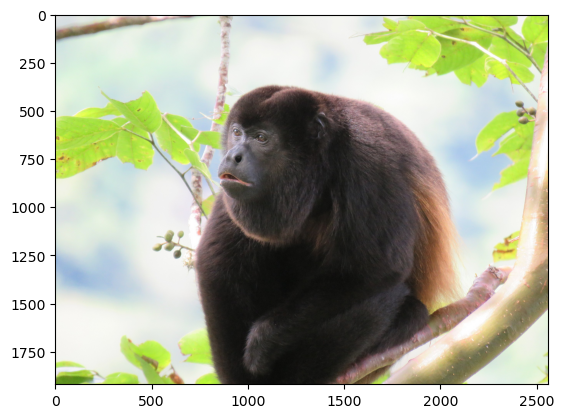

In [22]:
image = mpimg.imread(IMAGE)
image_plot = plt.imshow(image)

### 5.3) Predict monkey kind of test image

In [23]:
PREDICT_ENDPOINT = MODEL_ENDPOINT + "/infer"

test_image = cv2.resize(cv2.imread(IMAGE), dsize=(224, 224)) / 255.0

payload = {
    "inputs": [
        {
            "name": "inception_v3_input",
            "shape": [1, 224, 224, 3],
            "datatype": "FP32",
            "data": test_image.tolist(),
        }
    ]
}

res = requests.post(PREDICT_ENDPOINT, headers=HEADERS, data=json.dumps(payload))
response = json.loads(res.text)
response

{'model_name': 'monkey-classification',
 'model_version': '1',
 'outputs': [{'name': 'dense_2',
   'datatype': 'FP32',
   'shape': [1, 10],
   'data': [0.9977788329124451,
    0.0,
    0.0,
    0.0,
    7.601548299085807e-21,
    0.0,
    0.0,
    1.995984105370366e-27,
    0.0022211517207324505,
    0.0]}]}

Note you can also do this:
```curl -s -X POST -H "Host: $HOST" -d @$JSON_FILE $PREDICT_ENDPOINT```

In [24]:
print("Looks like a " + MONKEYS[np.argmax(response["outputs"][0]["data"])])

Looks like a Mantled howler (Alouatta palliata)
